<a href="https://colab.research.google.com/github/carolluzardi/analise_sirio_libanes/blob/main/Final_Project_DSBootcamp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Predicting the need for Intensive Care Units (ICUs) at Sírio Libanes Hospital (Sao Paulo and Brasilia, Brazil) from individual clinical data***

**Bootcamp Data Science Alura - Final Project**

By: Ana Carolina Moraes Luzardi (carolluzardi@gmail.com | [GitHub](https://github.com/carolluzardi) | [LinkedIn](https://www.linkedin.com/in/ana-carolina-moraes-luzardi-16600a11a/))

*March 2021*

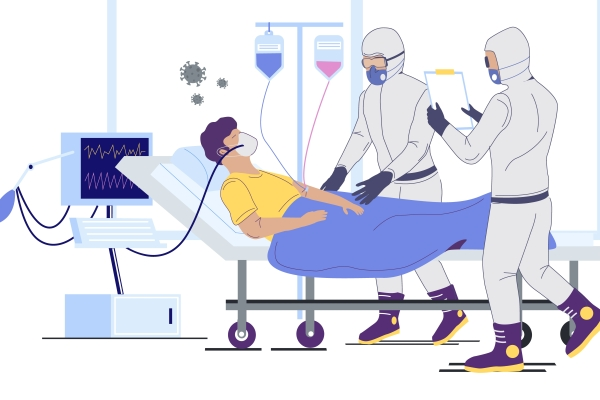

# **Problem Description**

**The problem**

The world is facing an unprecedented pandemic of COVID-19 disease. Breakdowns of health systems are being witnessed all around the world due to sudden COVID-19 spread. Hospitals don't have enough time to strengthen their resources so they can receive all patients that require intensive health care. Although the disease is not the most violent one, several people are dying due to lack of medical care avaibility.

But what if we could predict the number of ICUs a hospital will need in the close future so that the hospitals could prepare to receive the patients?

That's what we are exploring here. The objective of this project is to develop a machine learning model capable of predicting the number of ICUs needed in COVID-19 section of Sírio-Libanes hospital based on clinical data of the patients hours and / or days before their clinical picture worsens.

This approach could be used later to better arrange resources of hospitals during COVID-19 pandemic all around the world.

**Data information**

The data used here is available at the kaggle platform (https://www.kaggle.com/S%C3%ADrio-Libanes/covid19). The data has already been through a cleaning procedure.

The data is composed by four classes of features:

1. Patient demographic information (03 variables)
2. Patient previous grouped diseases (09 variables)
3. Blood results (36 variables)
4. Vital signs (06 variables)

**The solution**

# **Importing and pre-exploring the data**

OBS: Uncomment and run the following cell only if *openpyxl* package is not installed yet.

In [1]:
#pip install openpyxl

In [2]:
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split, cross_validate, RepeatedStratifiedKFold
from scipy.stats import randint
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from joblib import dump, load

In [3]:
path = 'https://github.com/carolluzardi/analise_sirio_libanes/blob/main/data/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true'
data = pd.read_excel(path, engine='openpyxl')
data.head(3)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.59322,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0,-0.162393,-0.5,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.59322,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0,-0.025641,-0.5,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1925 entries, 0 to 1924
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), object(2)
memory usage: 3.4+ MB


Above we can see that there are features in *data* DataFrame (for instance, *PATIENT_VISIT_IDENTIFIER*) that we can't use in the prediction. There are also missing ($\textit{NaN}$) values in some columns. Moreover, there are cateogrical data we need to deal with it so they can enter the machine learning model later. 

Before we begin the exploratory data analysis and building up the machine learning model, we will need to resolve those issues.

# **Data Preparation**

## Filling missing Data

The first step is to fill missing values in continual features.


The following are columns which are not continual in *data*:

'PATIENT_VISIT_IDENTIFIER', 'AGE_ABOVE65', 'AGE_PERCENTIL', 'GENDER',
       'DISEASE GROUPING 1', 'DISEASE GROUPING 2', 'DISEASE GROUPING 3',
       'DISEASE GROUPING 4', 'DISEASE GROUPING 5', 'DISEASE GROUPING 6', 'HTN',
       'IMMUNOCOMPROMISED', 'OTHER', 'WINDOW', 'ICU'

We need to ignore them when we fill the missing data.

The method for filling missing data is to propagate the last valid observation for each patient. When previous observation is not available, the next observation of that patient will be used instead.



In [5]:
def fill_missing_data(data):
    features_continual_columns = data.iloc[:, 13:-2].columns 
    features_continual = data.groupby("PATIENT_VISIT_IDENTIFIER", as_index=False)[features_continual_columns].fillna(method = "ffill").fillna(method="bfill")
    features_categorical = data.iloc[:, :13]
    out = data.iloc[:, -2:]
    data_final = pd.concat([features_categorical, features_continual, out], ignore_index=True, axis=1)
    data_final.columns = data.columns # dar nome as colunas
    return data_final
    

We should be careful not to propagate clinical data of when the patient is on ICU

In [6]:
data_clean = pd.concat([fill_missing_data(data.query('ICU==0')), data.query('ICU==1')], axis = 0)

What we want to know is if the patient needed ICU at the time $t$ based on the clinical data from previous data steps ($t-1$, $t-2$, etc.). 


When the patient arrived strait into the ICU, we don't have previous clinical data. Therefore, we should not consider those situations in our model.

Next we discard lines where the patient needed ICU (ICU==1) at first time step (WINDOW=='0-2'):

In [7]:
discard = data_clean.query("WINDOW =='0-2' and ICU==1")['PATIENT_VISIT_IDENTIFIER'].values
data_clean = data_clean.query('PATIENT_VISIT_IDENTIFIER not in @discard')

Eliminate any remaining missing data:

In [8]:
data_clean = data_clean.dropna()

## Preparation

Creating a column ICU_ANY that informs if in any moment the patient needed ICU.

In [9]:
data_clean["ICU_ANY"]=0
data_clean.head(2)

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU,ICU_ANY
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-1.0,0.086420,-0.230769,-0.283019,-0.59322,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0,-0.162393,-0.5,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0-2,0,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-1.0,0.333333,-0.230769,-0.132075,-0.59322,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0,-0.025641,-0.5,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2-4,0,0


In [10]:
def prepare_window(rows):
  if(np.any(rows['ICU'])):
    rows['ICU_ANY'] = 1
  return rows

In [11]:
data_clean = data_clean.groupby("PATIENT_VISIT_IDENTIFIER").apply(prepare_window)

We won't use the clinical data of when the patient is in need of ICU for the model, so we can discard it.

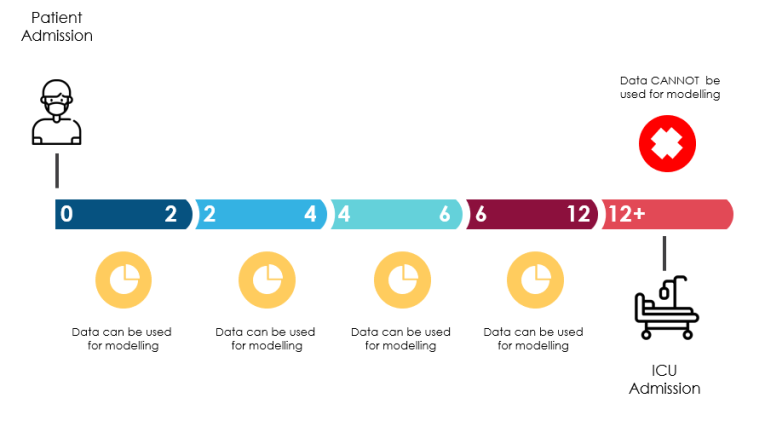

In [12]:
discard_2 = data_clean.query('ICU==1').index
data_clean.drop(discard_2, axis=0, inplace=True)

The column we need to predict now is ICU_ANY (i.e., if at any point that patient needed ICU), therefore the column ICU will not be used anymore. We can drop it from the DataFrame.

In [13]:
data_clean.drop('ICU', axis=1, inplace=True)

In [14]:
data_clean.head()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU_ANY
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,0-2,1
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,2-4,1
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,4-6,1
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.93895,-0.93895,...,-0.994912,-1.0,0.333333,-0.230769,-0.132075,-0.593220,-0.107143,0.736842,0.333333,-0.230769,-0.132075,-0.586207,-0.107143,0.736842,0.443299,0.0000,-0.025641,-0.500000,0.318681,0.898990,-0.076923,-0.459459,-0.313433,-0.636364,-0.275362,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,6-12,1
10,2,0,10th,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.6

## Dealing with categorical data

There are some columns in our DataFrame that are composed by strings. For example, AGE_PERCENTIL returns strings such as '40th', '50th', etc. They need to be converted to categorical before entering the model.

In [15]:
data_clean.AGE_PERCENTIL = data_clean.AGE_PERCENTIL.astype('category').cat.codes
data_clean.WINDOW = data_clean.WINDOW.astype('category').cat.codes

# **Feature selection**

The appropriate usage of fetures can reduce, enhance accuracy and a better understanding of the problem itself ([Jie et al., 2018 ](https://www.sciencedirect.com/science/article/pii/S0925231218302911)). 

In [16]:
data_clean.shape

(1405, 231)

The resulting DataFrame contains 231 columns and 1405 rows. Some of those columns may . Next I will evaluate wich columns should be used as predictors

## Visualization

**Is there a relationship between age and COVID-19 severity?**

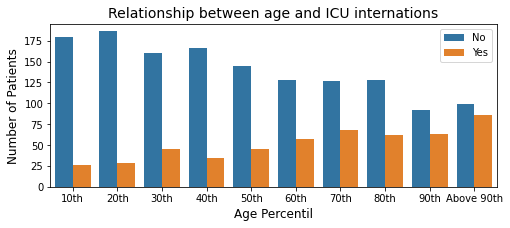

In [17]:
plt.figure(figsize=(8,3))
ax = sns.countplot(data=data, x ='AGE_PERCENTIL', hue = 'ICU', order = sorted(data['AGE_PERCENTIL'].unique()))
plt.ylabel('Number of Patients', fontsize=12)
plt.xlabel('Age Percentil', fontsize=12)
plt.title('Relationship between age and ICU internations', fontsize=14)
ax.legend(['No', 'Yes'])
plt.show()

The previous figure shows a clear increase of ICU internations with age percentil. Above the 90th percentil, almost 50% of COVID-19 cases require ICUs., whereas at the 10th percertil only about 10% of COVID-19 cases require ICUs. Those results agree with several papers found in literature which indicate that age is one of the major risk factors ([Kang et al., 2020](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7335648/)).

**Is there a relationship between gender and COVID-19 severity?**

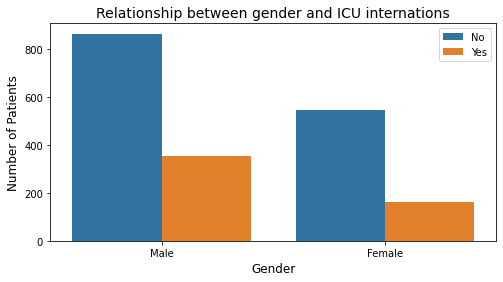

In [18]:
plt.figure(figsize=(8,4))
ax = sns.countplot(data=data, x ='GENDER', hue = 'ICU')
plt.ylabel('Number of Patients', fontsize=12)
plt.xlabel('Gender', fontsize=12)
ax.legend(['No', 'Yes'])
ax.set_xticklabels(['Male', 'Female'])
plt.title('Relationship between gender and ICU internations', fontsize=14)
plt.show()

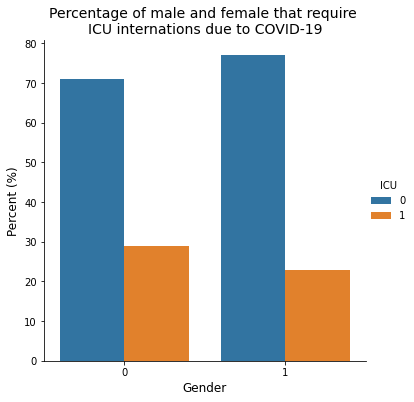

In [19]:
x,y = 'GENDER', 'ICU'
(data.groupby(x)[y].value_counts(normalize=True).mul(100).rename('Percent (%)').reset_index().pipe((sns.catplot,'data'), x=x,y='Percent (%)',hue=y,kind='bar'))
plt.xlabel('Gender', fontsize=12)
plt.ylabel('Percent (%)', fontsize=12)
plt.title('Percentage of male and female that require \nICU internations due to COVID-19', fontsize=14)
plt.show()

The first conclucion from those figures is that the number of males infected by COVID-19 is much higher than the number of females, which is in agreenment with bibliography. A recent study by [Jin et al. (2020)](https://www.frontiersin.org/articles/10.3389/fpubh.2020.00152/full?fbclid=IwAR0j28d7CvO1w_CKJyFyyaE4PkjERGrRNZQe4TdNo_XmBSQ_H-8ZQM_pjZ4) suggests that COVID-19 cases in men tend to be more serious than in woman. They also found that the mortality of men was about 2.4 times higher than in woman.
The fact that less woman arrived at the Sírio-Libanes Hospital indicates that COVID-19 cases in woman are less serious and more frequently they don't require any hospitalization at all. Moreover, the evolution to a UCI internation is also more frequent in males than females (i.e., from the percentage of peaople that arrive the hospital, there are more males than females; also the percentage of those who need ICU internation is higher between men).

## Select features based on Pearson Correlation

Remove all columns where Pearson correlation is lower than 0.2.

In [20]:
def pearson_corr(data_in):
  data_in = data_in.dropna()
  icu = data_in['ICU']
  data_in = data_in.select_dtypes(include='float64')
  correlation = []
  feature = []
  for col in data_in.columns:
    corr, _ = pearsonr(icu, data_in[col])
    correlation.append(corr)
    feature.append(col)
  df_pearson = pd.DataFrame(correlation, index = feature, columns=['PEARSON_CORR'])#.T
  return df_pearson

In [21]:
df_pearson = pearson_corr(data)
df_pearson.head(3)

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,PEARSON_CORR
DISEASE GROUPING 1,0.049768
DISEASE GROUPING 2,0.106990
DISEASE GROUPING 3,0.151449


In [22]:
df_pearson_greater = df_pearson[df_pearson['PEARSON_CORR'] >= 0.2]

In [23]:
print(df_pearson.shape)
print(df_pearson_greater.shape)

(225, 1)
(42, 1)


In [24]:
list1= df_pearson_greater.T.columns 
list2= data_clean.select_dtypes(include='int64').columns 
list3= data_clean.select_dtypes(include='int8').columns
selected_features = list1.tolist() + list2.tolist() + list3.tolist()

In [25]:
data_clean = data_clean[selected_features]

In [26]:
data_clean.shape

(1405, 48)

In [27]:
data_clean.head(3)

,HTN,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,LEUKOCYTES_MEDIAN,LEUKOCYTES_MEAN,LEUKOCYTES_MIN,LEUKOCYTES_MAX,NEUTROPHILES_MEDIAN,NEUTROPHILES_MEAN,NEUTROPHILES_MIN,NEUTROPHILES_MAX,UREA_MEDIAN,UREA_MEAN,UREA_MIN,UREA_MAX,BLOODPRESSURE_SISTOLIC_MEAN,RESPIRATORY_RATE_MEAN,RESPIRATORY_RATE_MEDIAN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,ICU_ANY,AGE_PERCENTIL,WINDOW
0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.835844,-0.835844,-0.835844,-0.835844,-0.868747,-0.868747,-0.868747,-0.868747,-0.836145,-0.836145,-0.836145,-0.836145,-0.230769,-0.59322,-0.586207,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1,0,1,5,0
1,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.835844,-0.835844,-0.835844,-0.835844,-0.868747,-0.868747,-0.868747,-0.868747,-0.836145,-0.836145,-0.836145,-0.836145,-0.230769,-0.59322,-0.586207,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1,0,1,5,1
2,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-0.835844,-0.835844,-0.835844,-0.835844,-0.868747,-0.868747,-0.868747,-0.868747,-0.836145,-0.836145,-0.836145,-0.836145,-0.230769,-0.59322,-0.586207,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,1,0,1,5,2


## Correlation matrix

One thing that can cause biases in machine learning models is to use features that correlate with each other. The correlation matrix will show us which features present cross-correlation. Next, for each pair of features that correlates, we will remove one of the features from the predictors.

In [28]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1405 entries, 0 to 1924
Data columns (total 48 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   HTN                               1405 non-null   float64
 1   BE_ARTERIAL_MEDIAN                1405 non-null   float64
 2   BE_ARTERIAL_MEAN                  1405 non-null   float64
 3   BE_ARTERIAL_MIN                   1405 non-null   float64
 4   BE_ARTERIAL_MAX                   1405 non-null   float64
 5   BE_VENOUS_MEDIAN                  1405 non-null   float64
 6   BE_VENOUS_MEAN                    1405 non-null   float64
 7   BE_VENOUS_MIN                     1405 non-null   float64
 8   BE_VENOUS_MAX                     1405 non-null   float64
 9   LEUKOCYTES_MEDIAN                 1405 non-null   float64
 10  LEUKOCYTES_MEAN                   1405 non-null   float64
 11  LEUKOCYTES_MIN                    1405 non-null   float64
 12  LEUKOC

There are 225 float64 type features, 4 int64 type features and 2 int8 type features. Let's see which are the non-float64 type features and decide if they should be used as predictors:

In [29]:
data_clean.select_dtypes(exclude='float64')

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,GENDER,ICU_ANY,AGE_PERCENTIL,WINDOW
0,0,1,0,1,5,0
1,0,1,0,1,5,1
2,0,1,0,1,5,2
3,0,1,0,1,5,3
10,2,0,0,1,0,0
...,...,...,...,...,...,...
1920,384,0,1,0,4,0
1921,384,0,1,0,4,1
1922,384,0,1,0,4,2
1923,384,0,1,0,4,3


The columns 

In [30]:
corr_matrix = data_clean.drop(['PATIENT_VISIT_IDENTIFIER', 'WINDOW', 'ICU_ANY'], axis=1).corr().abs() # matriz de correlacao

Removing the lower triangle of the correlation matrix so the columns won't be eliminated 

In [31]:
matrix_upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)) 

Visualizing the correlation matrix

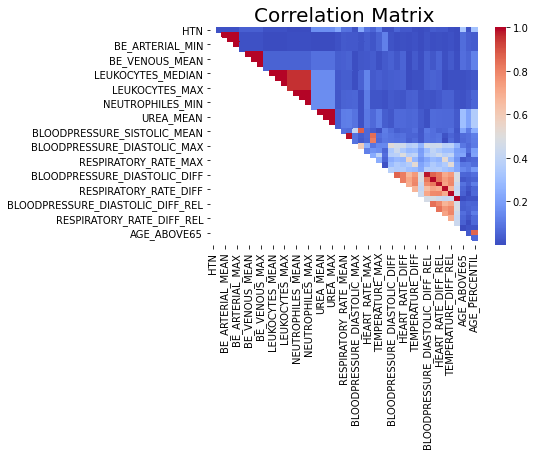

In [32]:
ax = sns.heatmap(matrix_upper.abs(), cmap='coolwarm')
ax.set_title('Correlation Matrix', fontsize=20)
plt.show()

Removing features that correlate more than 70 %

In [33]:
threshold=0.7
above_threshold = []
for col in matrix_upper.columns:
  if any(matrix_upper[col]>threshold):
    above_threshold.append(col)
    
data_clean = data_clean.drop(above_threshold, axis=1)

In [34]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1405 entries, 0 to 1924
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   HTN                           1405 non-null   float64
 1   BE_ARTERIAL_MEDIAN            1405 non-null   float64
 2   BE_VENOUS_MEDIAN              1405 non-null   float64
 3   LEUKOCYTES_MEDIAN             1405 non-null   float64
 4   UREA_MEDIAN                   1405 non-null   float64
 5   BLOODPRESSURE_SISTOLIC_MEAN   1405 non-null   float64
 6   RESPIRATORY_RATE_MEAN         1405 non-null   float64
 7   BLOODPRESSURE_DIASTOLIC_MAX   1405 non-null   float64
 8   HEART_RATE_MAX                1405 non-null   float64
 9   TEMPERATURE_MAX               1405 non-null   float64
 10  OXYGEN_SATURATION_MAX         1405 non-null   float64
 11  BLOODPRESSURE_DIASTOLIC_DIFF  1405 non-null   float64
 12  OXYGEN_SATURATION_DIFF        1405 non-null   float64
 13  PAT

# **Applying the machine mearning model**


Perfect! Now we need to create a function to run the chosen machine learning model.

## Standard model

In [35]:
def run_model_cv(model, data, n_splits, n_repeats):
    """
    Function to run machine learning models to predict dataset previously 
    cleaned and prepared. Overall, the function performs the data split, 
    training of the chosen model and the test score AUC.
    
    Input:
        model      - machine learning model function (sklearn)
                
        x          - Dataframe containing 

        y          - Dataframe containing previously selected features

        n_splits   - Specify the cross validation data split
                    
        s_repeats  - Number of repetition that will be done on splitting process 
                   to reduce model results variation
      """

    np.random.seed(9736)

    data.sample(frac=1).reset_index(drop=True)
    x_columns = data.columns
    y = data["ICU_ANY"]
    x = data[x_columns].drop(["ICU_ANY","WINDOW"], axis=1)

    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
    results = cross_validate(model, x, y, cv=cv, scoring='roc_auc')

    auc_mean = results['test_score'].mean()
    auc_std = results['test_score'].std()
    
    print(f'Mean AUC: {auc_mean}')
    print(f'{auc_mean-2*auc_std} - {auc_mean+2*auc_std}')
    
    return auc_mean

In [36]:
x = data_clean.drop(['ICU_ANY', 'WINDOW'], axis=1)
y = data_clean['ICU_ANY']
n_splits = 5
n_repeats = 10

In [37]:
model_etree = ExtraTreesClassifier()
run_model_cv(model_etree, data_clean, n_splits, n_repeats)

Mean AUC: 0.9891219953451075
0.9783365436249182 - 0.9999074470652968


0.9891219953451075

In [38]:
model_rforest = RandomForestClassifier()
run_model_cv(model_rforest, data_clean, n_splits, n_repeats)

Mean AUC: 0.9852739317636343
0.9730286334885991 - 0.9975192300386695


0.9852739317636343

In [39]:
model_dtree = DecisionTreeClassifier()
run_model_cv(model_dtree, data_clean, n_splits, n_repeats)

Mean AUC: 0.8900130370519386
0.8447169877666174 - 0.9353090863372597


0.8900130370519386

## Optimizing hyper parameters

Defining function to search for optimum hyper parameters

In [40]:
def run_model_cv_optimum(model, data, n_splits, n_repeats, params_space, n_iter):
    """
    Function to run machine learning models to predict dataset previously 
    cleaned and prepared. Overall, the function performs the data split, 
    training of the chosen model and the test score AUC.
    
    Input:
        model        - machine learning model function (sklearn)
                
        x            - Dataframe containing 

        y            - Dataframe containing previously selected features

        n_splits     - Specify the cross validation data split
                    
        s_repeats    - Number of repetition that will be done on splitting process 
                     to reduce model results variation

        params_space  - Dictionary contaning a space of possible parameters

        n_iter        - Number of iterations to choose the optimum parameters
      """

    np.random.seed(9736)

    data.sample(frac=1).reset_index(drop=True)
    x_columns = data.columns
    y = data["ICU_ANY"]
    x = data[x_columns].drop(["ICU_ANY","WINDOW"], axis=1)

    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
    search = RandomizedSearchCV(model, param_distributions = params_space,
                           n_iter = n_iter, cv = cv, scoring='roc_auc',
                           return_train_score=True)
    search.fit(x, y)

    results = pd.DataFrame(search.cv_results_)

    auc_mean = results.iloc[search.best_index_]['mean_test_score']
    auc_mean_train = results.iloc[search.best_index_]['mean_train_score']
    auc_std = results.iloc[search.best_index_]['std_test_score']

    
    print(f'TEST mean AUC: {auc_mean}')
    print(f'TRAIN mean AUC: {auc_mean_train}')
    print(f'{auc_mean-2*auc_std} - {auc_mean+2*auc_std}')
    
    return auc_mean, auc_mean_train, results.iloc[search.best_index_]

Defining dictionary containing a range of possible parameters, and defining the number of iteration to choose the best parameters within this range

In [41]:
params_space = {
    "n_estimators" :randint(50, 200),
    "min_samples_split" : randint(2, 10),
    "min_samples_leaf" : randint(1, 10),
    "bootstrap" : [True, False],
    "criterion" : ["gini", "entropy"]
}

params_space_dtree = {
    "min_samples_split" : randint(2, 10),
    "min_samples_leaf" : randint(1, 10),
    "criterion" : ["gini", "entropy"]
}

n_iter = 10

### Random Forest Classifier

In [42]:
model_rforest = RandomForestClassifier()
_, __, best_index = run_model_cv_optimum(model_rforest, data_clean, n_splits, n_repeats, params_space, n_iter)

TEST mean AUC: 0.9849060527573115
TRAIN mean AUC: 1.0
0.9691982229033176 - 1.0006138826113053


In [43]:
model_rforest_optimum = RandomForestClassifier(n_estimators = best_index['param_n_estimators'], 
                                       min_samples_split = best_index['param_min_samples_split'],
                                       min_samples_leaf = best_index['param_min_samples_leaf'], 
                                       bootstrap = best_index['param_bootstrap'], 
                                       criterion = best_index['param_criterion'])

### Extra Trees Classifier 

In [44]:
model_etree = ExtraTreesClassifier()
_, __, best_index = run_model_cv_optimum(model_etree, data_clean, n_splits, n_repeats, params_space, n_iter)

TEST mean AUC: 0.9822996370524973
TRAIN mean AUC: 0.9999814754231329
0.9643203523293251 - 1.0002789217756696


In [45]:
model_etree_optimum = ExtraTreesClassifier(n_estimators = best_index['param_n_estimators'], 
                                       min_samples_split = best_index['param_min_samples_split'],
                                       min_samples_leaf = best_index['param_min_samples_leaf'], 
                                       bootstrap = best_index['param_bootstrap'], 
                                       criterion = best_index['param_criterion'])

### Decision Tree Classifier 

In [46]:
model_dtree = DecisionTreeClassifier()
_, __, best_index = run_model_cv_optimum(model_dtree, data_clean, n_splits, n_repeats, params_space_dtree, n_iter)

TEST mean AUC: 0.8893381675109366
TRAIN mean AUC: 0.9966910682059286
0.8457216940481795 - 0.9329546409736937


In [47]:
model_dtree_optimum = DecisionTreeClassifier(min_samples_split = best_index['param_min_samples_split'],
                                       min_samples_leaf = best_index['param_min_samples_leaf'], 
                                       criterion = best_index['param_criterion'])

### **Best model with optimum parameters**

Random Forest Classifier performed better than Decision Tree Classifier and Extra Trees Classifier.

Finally, Random Forest Model trained with optimum parameter can now be saved.

In [48]:
x_columns = data_clean.columns
y = data_clean["ICU_ANY"]
x = data_clean[x_columns].drop(["ICU_ANY","WINDOW"], axis=1)

In [49]:
model_rforest_optimum.fit(x, y)

dump(model_rforest_optimum, 'model_rforest_optimum.joblib') 

['model_rforest_optimum.joblib']

# Conclusion